<a id='sec0'></a>

# Optimizing n-class word extraction1 : relative difference

The extracted words here will be combined with others extracted in different ways

<a href='#sec1'><b>1. Import and pre-process data</b></a>

<a href='#sec2'><b>2. Create features based on frequency paramerization</b></a>
   
<a href='#sec3'><b>3. PCA & LDA</b></a>

In [1]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import importlib as imp
import feature_engineering.frequency_selection as fefs
import myplot.decomposition as mpd

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

Using TensorFlow backend.
Slow version of gensim.models.doc2vec is being used


<a id='sec1'></a>
# 1. Import and pre-process data
(<a href='#sec0'>Back to top</a>)

In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep=r"\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

In [3]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

perdoc_apps = pd.DataFrame(ave_perdoc_apps).fillna(value=0)

In [4]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 342 ms, sys: 7.83 ms, total: 350 ms
Wall time: 350 ms


<a id='sec2'></a>
# 2. Create features based on frequency paramerization
- Use parameter sets from notebook 2_04 and 2_05
- Best of 'relative': min_diff=1.35, min_freq=0.45, min_excl_freq=0.175(or 0.2)
- Best of 'absolute': min_diff=0.10, min_freq=0.60

(<a href='#sec0'>Back to top</a>)

In [5]:
ncw_relative = fefs.getNClassWords(fracdocs_update1, doc_type='fraction_of_docs',
                            mode='relative', min_frequency=0.45,
                            min_difference=1.35, print_result=True)
ncw_absolute = fefs.getNClassWords(fracdocs_update1, doc_type='fraction_of_docs',
                            mode='absolute', min_frequency=0.6,
                            min_difference=0.1, print_result=True)
ncw_exclusive = fefs.getNClassExclusiveWords(fracdocs_update1, min_frequency=0.175, print_result=True)
words1 = fefs.selectNClassWords(ncw_relative, n=8)
words2 = fefs.selectNClassWords(ncw_absolute, n=8)
words3 = fefs.selectNClassWords(ncw_exclusive, n=8)
select_words = set((words1 + words2 + words3))

print("'Relative' extraction: %d words" % len(words1))
print("'Absolute' extraction: %d words" % len(words2))
print("'Exclusive' extraction: %d words" % len(words3))
print("# unique words extracted: %d words" % len(select_words))

====== n-class words extractions by relative differecne ======
Input Type: fraction_of_docs
Minimum Difference = 1.35
Minimum Frequency = 0.45
# of words in one_class_words: 185
# of words in two_class_words: 56
# of words in three_class_words: 5
# of words in four_class_words: 7
# of words in five_class_words: 2
# of words in six_class_words: 3
# of words in seven_class_words: 19
# of words in eight_class_words: 36
# of words in other_words: 124842
Total # of words: 125155
====== n-class words extractions by absolute differecne ======
Input Type: fraction_of_docs
Minimum Difference = 0.10
Minimum Frequency = 0.60
# of words in one_class_words: 176
# of words in two_class_words: 50
# of words in three_class_words: 7
# of words in four_class_words: 5
# of words in five_class_words: 6
# of words in six_class_words: 3
# of words in seven_class_words: 6
# of words in eight_class_words: 6
# of words in other_words: 124897
Total # of words: 125156
===== n-class words extractions by exclusive

In [6]:
# Try RFC on the features above with same random states as before
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)
result = fefs.RFC_CustomWords(unclassified_tokenized_docs, fracdocs_update1, y, 
                                select_words, vector_type='tfidf', test_size=0.15, 
                                random_state=345, verbose=True,rfc=rfc)

448 words selected...
Vectorizating texts...
5 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.635
 - Log Loss: 1.088


<a id='sec3'></a>
# 3. RFECV
<a href='#sec0'>Back to top</a>

<b>Recursive feature elimination with RandomForest</b>

In [7]:
X = result['feature_matrix']
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)

In [8]:
%%time
selector = RFECV(rfc, step=2, scoring='neg_log_loss', n_jobs=8)
selector = selector.fit(X, y)

CPU times: user 11 s, sys: 369 ms, total: 11.4 s
Wall time: 2min 57s


<b>Create a feature matrix and a list of retained words</b>

In [9]:
print('# Features Retained %d' % selector.n_features_)
rfe_indices = list(np.argwhere(selector.support_ == True).ravel())
selectX = X[:, rfe_indices]
print('Dimension of new matrix', selectX.shape)

# Features Retained 444
Dimension of new matrix (3321, 444)


In [10]:
feature_ids = result['feature_ids']
rfe_features = [key for key, value in feature_ids.items() \
                if value in rfe_indices]
print(len(rfe_features))

444


In [19]:
(pd.Series(rfe_features)).to_csv('./data/frequency_based_features_rfe.csv', index=False)

<b>Check for the performance of the retained features" Using new matrix</b>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15)
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)
rfc.fit(X_train, y_train)
print('Accuracy: %.3f' % accuracy_score(y_test, rfc.predict(X_test)))
print('Log Loss: %.3f' % log_loss(y_test, rfc.predict_proba(X_test)))

Accuracy: 0.679
Log Loss: 1.038


<b>Check for the performance of the retained features" Using words list</b>

In [13]:
# Try RFC on the features above with same random states as before
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)
result2 = fefs.RFC_CustomWords(unclassified_tokenized_docs, fracdocs_update1, y, 
                                rfe_features, vector_type='tfidf', test_size=0.15, 
                                verbose=True,rfc=rfc)

444 words selected...
Vectorizating texts...
5 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.635
 - Log Loss: 1.034


<a id='sec4'></a>
# 4. PCA & LDA
<a href='#sec0'>Back to top</a>

<b>PCA</b>

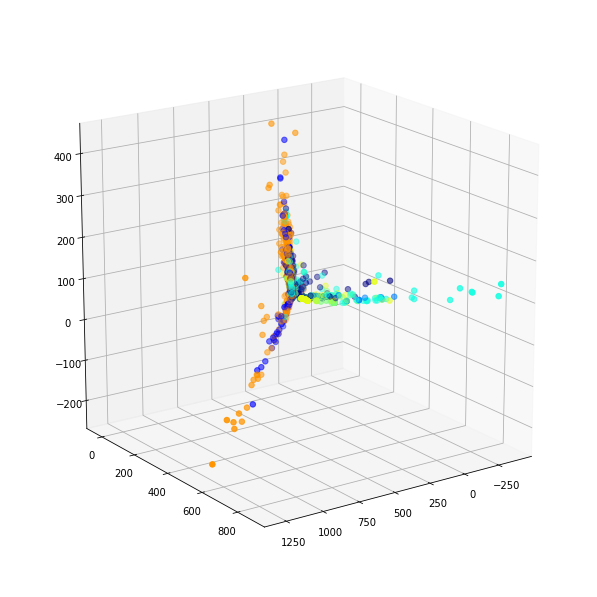

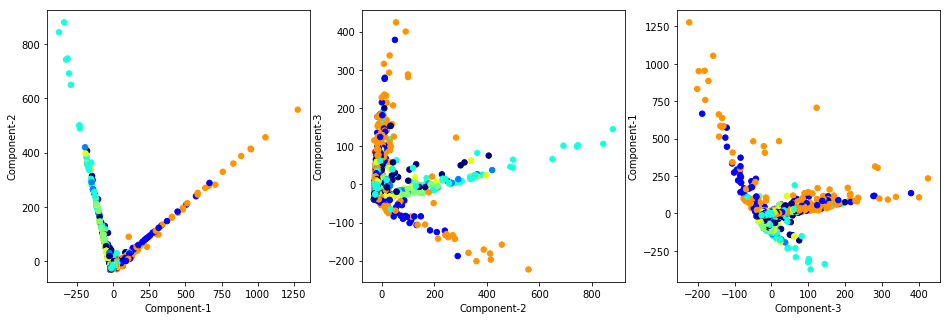

In [14]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'])
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [15]:
%%time
pca = PCA()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)
print(X_test.shape, X_test_pca.shape)

rfc.fit(X_train_pca, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_pca))
lloss = log_loss(y_test, rfc.predict_proba(X_test_pca), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 444) (2822, 444)
(499, 444) (499, 444)
Accuracy 0.589
Log Loss 1.592
CPU times: user 4.41 s, sys: 23.4 ms, total: 4.43 s
Wall time: 1.35 s


<b>LDA</b>

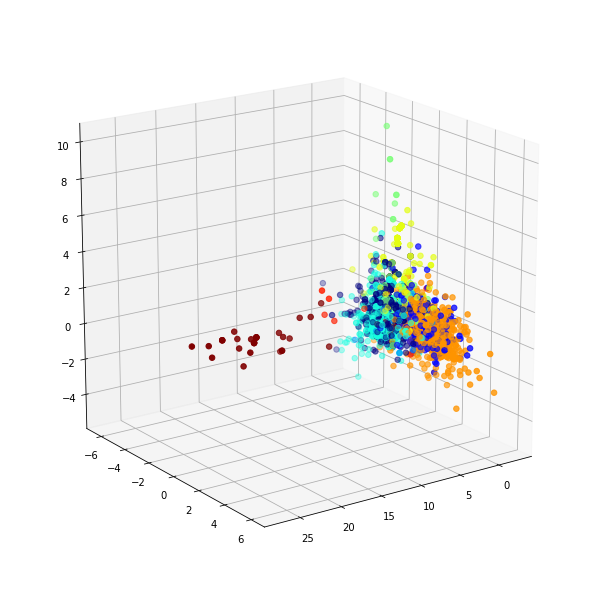

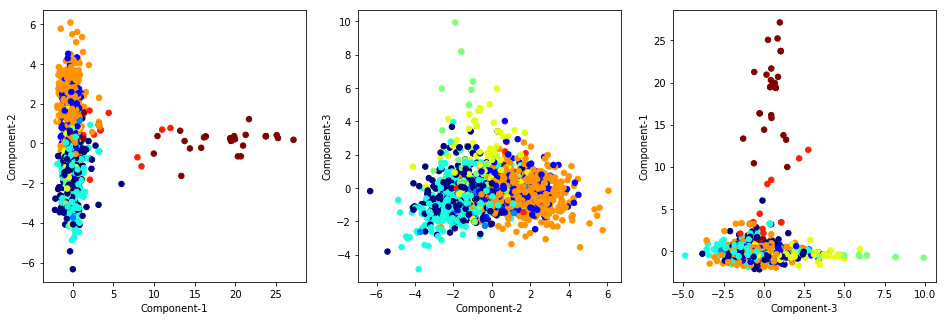

In [16]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                y=y, decomposer=LinearDiscriminantAnalysis(n_components=3))
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [17]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 444) (2822, 8)
(499, 444) (499, 8)
Accuracy 0.595
Log Loss 2.061
CPU times: user 951 ms, sys: 21.3 ms, total: 972 ms
Wall time: 769 ms


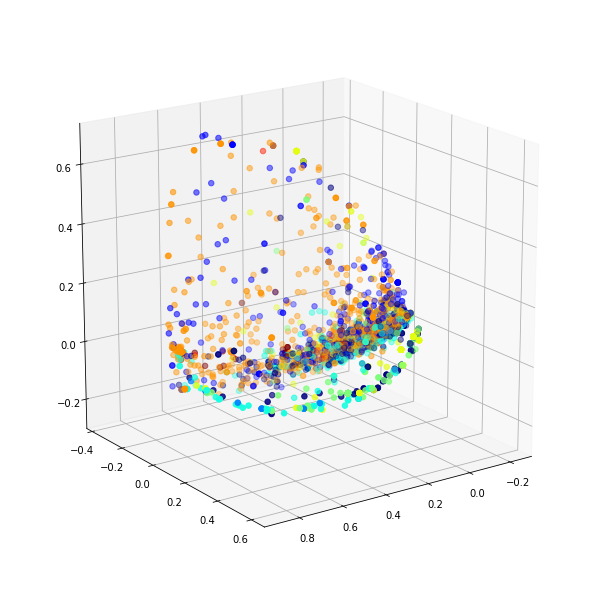

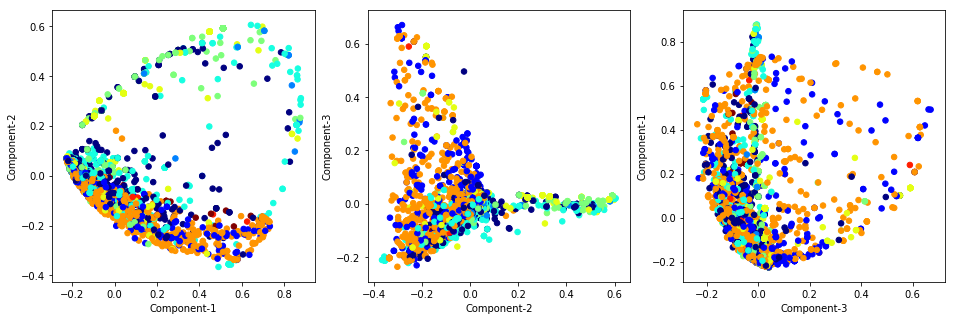

In [18]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="rbf", gamma=0.000015, n_components=3, n_jobs=8)
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                                y=y, decomposer=kpca)
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])